# Entrenamiento del modelo 

# Grupo 2

# usamos el dataset resultante del proceso de FE

In [28]:
%cd /app

/app


/usr/local/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning:

This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.



In [29]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
import optuna
from optuna.artifacts import FileSystemArtifactStore, upload_artifact
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import cohen_kappa_score, accuracy_score, balanced_accuracy_score, classification_report
from sklearn.utils import shuffle
from joblib import dump
import matplotlib.pyplot as plt
from UA_MDM_LDI_II.tutoriales.utils import plot_confusion_matrix
from sklearn.preprocessing import LabelEncoder



In [30]:
# Paths
BASE_DIR = './'
PATH_TO_TRAIN_FE_TEXT_LLM = os.path.join(BASE_DIR, "input/petfinder-adoption-prediction/train/train_fe_text_llm.csv")
PATH_TO_MODELS = os.path.join(BASE_DIR, "UA_MDM_LDI_II/work/models")
PATH_TO_TEMP_FILES = os.path.join(BASE_DIR, "UA_MDM_LDI_II/work/optuna_temp_artifacts")
PATH_TO_OPTUNA_ARTIFACTS = os.path.join(BASE_DIR, "UA_MDM_LDI_II/work/optuna_artifacts")

SEED = 42
TEST_SIZE = 0.2



In [31]:
# Datos Tabulares
dataset = pd.read_csv(PATH_TO_TRAIN_FE_TEXT_LLM)

#Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,IsPureBreed,AgeInYears,Healthy,Overall_Health,IsFree,Breed1_Rarity,ColorQuantity,TotalMedia,StatePopulation,IsPeninsular,SentimentScore,SentimentMagnitude,SentimentLanguage,contains_dog,contains_friendly,contains_spayed,contains_good,contains_loving,contains_forever,contains_need,contains_home,contains_year,contains_life,contains_kitten,contains_email,contains_adoption,contains_litter,contains_sibling,contains_long,contains_new,contains_adopted,contains_week,contains_thank,coherence,requires_running_space,friendly_with_children,friendly_with_other_pets,is_calm,is_energetic,inconsistencies

# Convertir columnas de objetos a categóricas o numéricas
label_encoders = {}
categorical_columns = ['SentimentLanguage', 'Overall_Health', 'coherence', 'friendly_with_children', 'friendly_with_other_pets', 'is_calm']

for col in categorical_columns:
    le = LabelEncoder()
    dataset[col] = le.fit_transform(dataset[col].astype(str))
    label_encoders[col] = le

# Split del dataset
train, test = train_test_split(dataset, test_size=TEST_SIZE, random_state=SEED, stratify=dataset.AdoptionSpeed)

# Seleccionar características y etiqueta
features = ['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2', 'Color3', 'MaturitySize', 
            'FurLength', 'Vaccinated', 'Dewormed', 'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 
            'VideoAmt', 'PhotoAmt', 'IsPureBreed', 'AgeInYears', 'Healthy', 'Overall_Health',  'IsFree', 'Breed1_Rarity', 'ColorQuantity', 'TotalMedia',
            'StatePopulation', 'IsPeninsular', 'SentimentScore', 'SentimentMagnitude', 'SentimentLanguage'] + \
           [col for col in dataset.columns if col.startswith('contains_')] + \
           ['coherence', 'requires_running_space', 'friendly_with_children', 'friendly_with_other_pets', 
            'is_calm', 'is_energetic']

label = 'AdoptionSpeed'

X_train = train[features]
y_train = train[label]

X_test = test[features]
y_test = test[label]


/tmp/ipykernel_2765521/1909255214.py:2: DtypeWarning:

Columns (61) have mixed types. Specify dtype option on import or set low_memory=False.



In [32]:
# Entrenamiento inicial
lgb_params = {
#    'device' : 'gpu', 
    'force_row_wise': True,
    'objective': 'multiclass',
    'num_class': len(y_train.unique())
}

lgb_train_dataset = lgb.Dataset(data=X_train, label=y_train)

lgb_model = lgb.train(lgb_params, lgb_train_dataset)

y_pred = lgb_model.predict(X_test).argmax(axis=1)

print("Cohen Kappa Score Inicial:", cohen_kappa_score(y_test, y_pred, weights='quadratic'))
display(plot_confusion_matrix(y_test, y_pred))



[LightGBM] [Info] Total Bins 881
[LightGBM] [Info] Number of data points in the train set: 11994, number of used features: 58
[LightGBM] [Info] Start training from score -3.599148
[LightGBM] [Info] Start training from score -1.579379
[LightGBM] [Info] Start training from score -1.311924
[LightGBM] [Info] Start training from score -1.526206
[LightGBM] [Info] Start training from score -1.273359
Cohen Kappa Score Inicial: 0.3350371671316231


In [33]:
#lgb.plot_importance(lgb_model, height=0.5, figsize=(10, 12))
#plt.show()

In [34]:
# Optimización de Hiperparámetros con Optuna
#def lgb_objective(trial):
#    lgb_params = {
#        'force_row_wise': True, #aceptando sugerencia de lightgbm
#        'objective': 'multiclass',
#        'verbosity': -1,
#        'num_class': len(y_train.unique()),
#        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
#        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
#        'num_leaves': trial.suggest_int('num_leaves', 10, 300),  # Ampliado
#        'feature_fraction': trial.suggest_float('feature_fraction', 0.3, 1.0),  # Ampliado
#        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.3, 1.0),  # Ampliado
#        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),  # Ampliado
#        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),  # Ampliado
#    }
#    
#    lgb_train_dataset = lgb.Dataset(data=X_train, label=y_train)
#    lgb_model = lgb.train(lgb_params, lgb_train_dataset)
#    
#    return cohen_kappa_score(y_test, lgb_model.predict(X_test).argmax(axis=1), weights='quadratic')

# Función para Cross-Validation y Early Stopping
def lgb_custom_metric_kappa(dy_pred, dy_true):
    metric_name = 'kappa'
    value = cohen_kappa_score(dy_true.get_label(), dy_pred.argmax(axis=1), weights='quadratic')
    is_higher_better = True
    return metric_name, value, is_higher_better

#def cv_es_lgb_objective(trial):
#    lgb_params = {
#        'objective': 'multiclass',
#        'verbosity': -1,
#        'num_class': len(y_train.unique()),
#        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
#        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
#        'num_leaves': trial.suggest_int('num_leaves', 10, 300),  # Ampliado
#        'feature_fraction': trial.suggest_float('feature_fraction', 0.3, 1.0),  # Ampliado
#        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.3, 1.0),  # Ampliado
#        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),  # Ampliado
#        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),  # Ampliado
#    }

def cv_es_lgb_objective(trial):
    lgb_params = {
        'objective': 'multiclass',
        'verbosity': -1,
        'num_class': len(y_train.unique()),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-6, 1e0, log=True),  # Rango más amplio
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-6, 1e0, log=True),  # Rango más amplio
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),  # Rango más reducido
        'feature_fraction': trial.suggest_float('feature_fraction', 0.3, 0.8),  # Ajustado
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 0.9),  # Ajustado
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),  # Ajustado ligeramente
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),  # Rango más elevado
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 0.5),  # Nuevo hiperparámetro
        'max_depth': trial.suggest_int('max_depth', -1, 20)  # Nuevo hiperparámetro
    }

    scores_ensemble = np.zeros((len(y_test), len(y_train.unique())))
    score_folds = 0
    n_splits = 5

    skf = StratifiedKFold(n_splits=n_splits)

    for i, (if_index, oof_index) in enumerate(skf.split(X_train, y_train)):
        lgb_if_dataset = lgb.Dataset(data=X_train.iloc[if_index], label=y_train.iloc[if_index], free_raw_data=False)
        lgb_oof_dataset = lgb.Dataset(data=X_train.iloc[oof_index], label=y_train.iloc[oof_index], free_raw_data=False)

        lgb_model = lgb.train(
            lgb_params,
            lgb_if_dataset,
            valid_sets=lgb_oof_dataset,
            callbacks=[lgb.early_stopping(10, verbose=False)],
            feval=lgb_custom_metric_kappa
        )

        scores_ensemble += lgb_model.predict(X_test)
        score_folds += cohen_kappa_score(y_train.iloc[oof_index], lgb_model.predict(X_train.iloc[oof_index]).argmax(axis=1), weights='quadratic') / n_splits

    predicted_filename = os.path.join(PATH_TO_TEMP_FILES, f'test_{trial.study.study_name}_{trial.number}.joblib')
    predicted_df = test.copy()
    predicted_df['pred'] = [scores_ensemble[p, :] for p in range(scores_ensemble.shape[0])]
    dump(predicted_df, predicted_filename)
    upload_artifact(trial, predicted_filename, artifact_store)

    cm_filename = os.path.join(PATH_TO_TEMP_FILES, f'cm_{trial.study.study_name}_{trial.number}.jpg')
    plot_confusion_matrix(y_test, scores_ensemble.argmax(axis=1)).write_image(cm_filename)
    upload_artifact(trial, cm_filename, artifact_store)

    test_score = cohen_kappa_score(y_test, scores_ensemble.argmax(axis=1), weights='quadratic')
    trial.set_user_attr("test_score", test_score)

    return score_folds



In [35]:
# Crear estudio de Optuna
study_name = "05 - LGB Multiclass CV 06"  # Nuevo nombre de estudio
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)



/tmp/ipykernel_2765521/1555603172.py:3: ExperimentalWarning:

FileSystemArtifactStore is experimental (supported from v3.3.0). The interface can change in the future.



In [36]:
study = optuna.create_study(direction='maximize', storage="sqlite:///db.sqlite3", study_name=study_name, load_if_exists=True)


[I 2024-07-03 02:32:56,363] A new study created in RDB with name: 05 - LGB Multiclass CV 06


In [37]:
study.optimize(cv_es_lgb_objective, n_trials=300)  # Aumentar el número de trials

/tmp/ipykernel_2765521/1358195452.py:84: ExperimentalWarning:

upload_artifact is experimental (supported from v3.3.0). The interface can change in the future.

/tmp/ipykernel_2765521/1358195452.py:88: ExperimentalWarning:

upload_artifact is experimental (supported from v3.3.0). The interface can change in the future.

[I 2024-07-03 02:33:04,161] Trial 0 finished with value: 0.2195881877710005 and parameters: {'lambda_l1': 0.0004727764944651123, 'lambda_l2': 0.8955287245341094, 'num_leaves': 47, 'feature_fraction': 0.5589684909332189, 'bagging_fraction': 0.8699414105468073, 'bagging_freq': 3, 'min_child_samples': 29, 'min_split_gain': 0.4968990238267089, 'max_depth': 1}. Best is trial 0 with value: 0.2195881877710005.
/tmp/ipykernel_2765521/1358195452.py:84: ExperimentalWarning:

upload_artifact is experimental (supported from v3.3.0). The interface can change in the future.

/tmp/ipykernel_2765521/1358195452.py:88: ExperimentalWarning:

upload_artifact is experimental (supported from

In [38]:
# Obtener los mejores hiperparámetros
best_params = study.best_params
print("Mejores hiperparámetros:", best_params)

# Entrenar el modelo final con los mejores hiperparámetros
lgb_params = {      
    'objective': 'multiclass',
    'verbosity': -1,
    'num_class': len(y_train.unique())
}
lgb_params.update(best_params)
lgb_train_dataset = lgb.Dataset(data=X_train, label=y_train)
lgb_model = lgb.train(lgb_params, lgb_train_dataset)



Mejores hiperparámetros: {'lambda_l1': 0.44852999188082976, 'lambda_l2': 0.012095769941200563, 'num_leaves': 90, 'feature_fraction': 0.5535619473217577, 'bagging_fraction': 0.8752422474373073, 'bagging_freq': 1, 'min_child_samples': 24, 'min_split_gain': 0.18367682277342431, 'max_depth': 18}


Kappa: 0.3311281592324009
Accuracy: 0.3947982660886962
Balanced Accuracy: 0.32694233857056554


Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.38      0.07      0.12        82
           1       0.33      0.33      0.33       618
           2       0.33      0.38      0.35       807
           3       0.37      0.26      0.31       652
           4       0.50      0.60      0.54       840

    accuracy                           0.39      2999
   macro avg       0.38      0.33      0.33      2999
weighted avg       0.39      0.39      0.39      2999



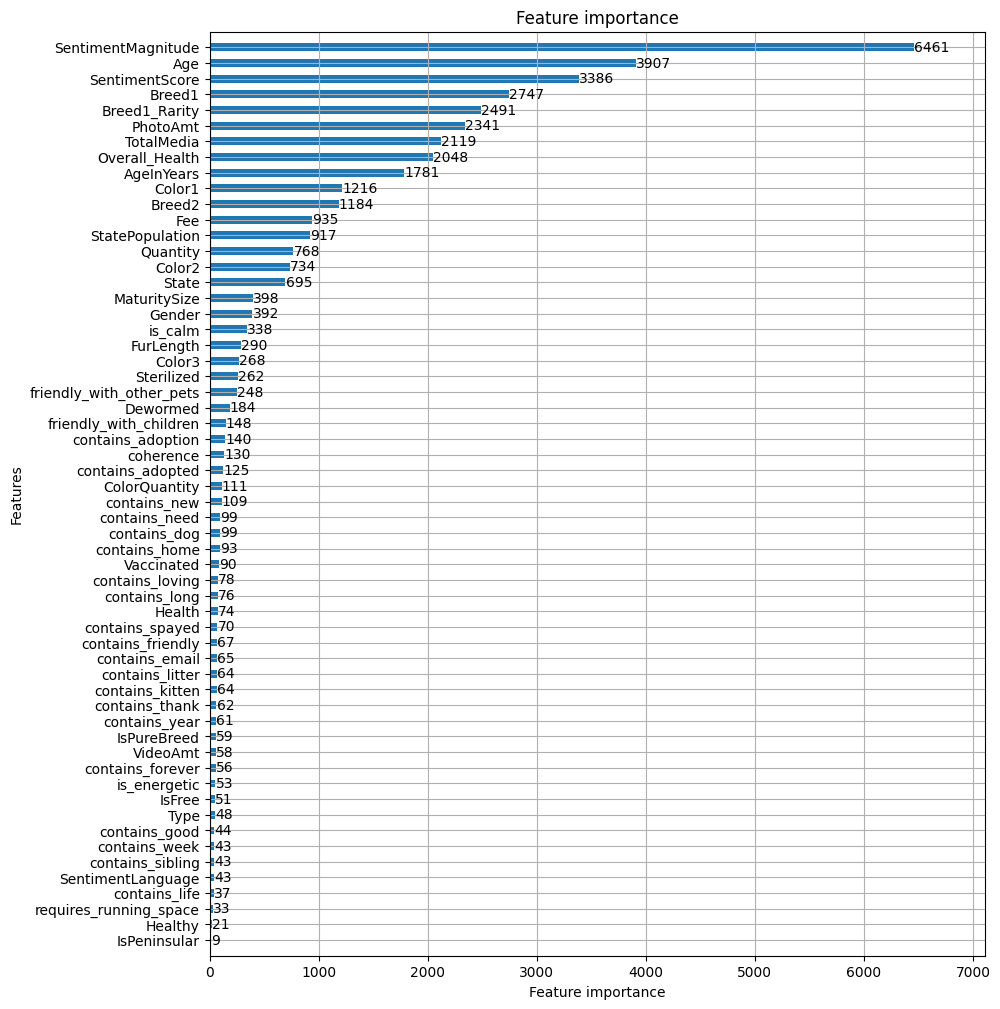

Total de datos en el dataset de entrenamiento: 11994
Datos utilizados en el entrenamiento actual: 11994
Porcentaje de datos utilizados: 100.00%


In [39]:
# Evaluar el modelo en el conjunto de prueba
y_pred = lgb_model.predict(X_test).argmax(axis=1)
kappa_score = cohen_kappa_score(y_test, y_pred, weights='quadratic')
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

print(f'Kappa: {kappa_score}')
print(f'Accuracy: {accuracy}')
print(f'Balanced Accuracy: {balanced_accuracy}')

# Mostrar la matriz de confusión
display(plot_confusion_matrix(y_test, y_pred))

# Información adicional del modelo
print("Reporte de clasificación:\n", classification_report(y_test, y_pred))
lgb.plot_importance(lgb_model, height=0.5, figsize=(10, 12))
plt.show()

# Tamaño total del dataset de entrenamiento
total_data = X_train.shape[0]
train_data = X_train.shape[0]
percentage_used = (train_data / total_data) * 100

print(f"Total de datos en el dataset de entrenamiento: {total_data}")
print(f"Datos utilizados en el entrenamiento actual: {train_data}")
print(f"Porcentaje de datos utilizados: {percentage_used:.2f}%")


<Figure size 1500x800 with 0 Axes>

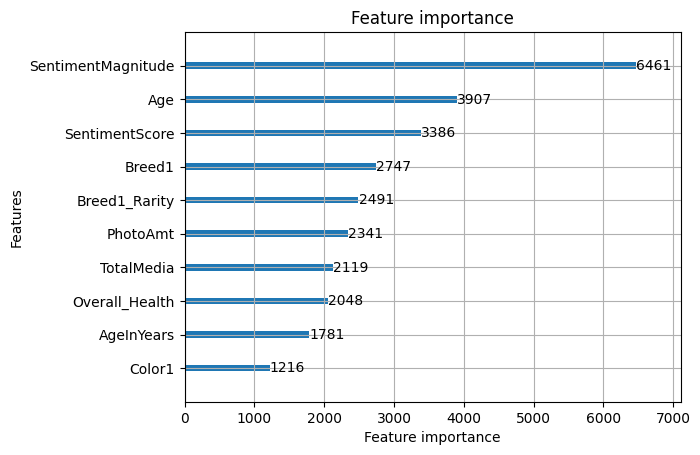

In [40]:
importance_df = pd.DataFrame({
    'feature': lgb_model.feature_name(),
    'importance': lgb_model.feature_importance()
}).sort_values('importance', ascending=False)

# Mostrar las 10 características más importantes
plt.figure(figsize=(15, 8))
lgb.plot_importance(lgb_model, max_num_features=10)
plt.show()

# Análisis opcional

In [ ]:
# Analizar los últimos 30 resultados de la optimización

In [41]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import cohen_kappa_score, accuracy_score, balanced_accuracy_score
from UA_MDM_LDI_II.tutoriales.utils import plot_confusion_matrix

# Obtener todos los trials
all_trials = study.trials

# Ordenar los trials por su valor (score) en orden descendente
sorted_trials = sorted(all_trials, key=lambda x: x.value, reverse=True)

# Seleccionar los 10 mejores trials
best_trials = sorted_trials[:30]

results = []

for trial in best_trials:
    params = trial.params

    # Entrenar un modelo con los hiperparámetros del trial
    lgb_params = {
        'objective': 'multiclass',
        'verbosity': -1,
        'num_class': len(y_train.unique())
    }
    lgb_params.update(params)
    lgb_train_dataset = lgb.Dataset(data=X_train, label=y_train)
    lgb_model = lgb.train(lgb_params, lgb_train_dataset)

    # Evaluar el modelo en entrenamiento y test
    y_pred_train = lgb_model.predict(X_train).argmax(axis=1)
    y_pred_test = lgb_model.predict(X_test).argmax(axis=1)

    kappa_train = cohen_kappa_score(y_train, y_pred_train, weights='quadratic')
    kappa_test = cohen_kappa_score(y_test, y_pred_test, weights='quadratic')

    # Calcular la diferencia entre Kappa de entrenamiento y test
    kappa_diff = abs(kappa_train - kappa_test)

    # Evaluar la tendencia al overfitting
    overfitting_tendency = 'Baja'
    if params['lambda_l1'] < 1e-5 or params['lambda_l2'] < 1e-5:
        overfitting_tendency = 'Media'
    if params['num_leaves'] > 100 or (params['feature_fraction'] > 0.8 and params['bagging_fraction'] > 0.8) or params['min_child_samples'] < 20:
        overfitting_tendency = 'Alta'

    # Calcular otras métricas
    accuracy = accuracy_score(y_test, y_pred_test)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred_test)

    # Generar la matriz de confusión
    #cm = plot_confusion_matrix(y_test, y_pred_test)
    #display(plot_confusion_matrix(y_test, y_pred))


    # Agregar resultados a la lista
    results.append({
        'Trial': trial.number,
        'lambda_l1': params['lambda_l1'],
        'lambda_l2': params['lambda_l2'],
        'num_leaves': params['num_leaves'],
        'feature_fraction': params['feature_fraction'],
        'bagging_fraction': params['bagging_fraction'],
        'bagging_freq': params['bagging_freq'],
        'min_child_samples': params['min_child_samples'],
        'Kappa (Train)': kappa_train,
        'Kappa (Test)': kappa_test,
        'Diferencia Kappa': kappa_diff,
        'Accuracy': accuracy,
        'Balanced Accuracy': balanced_accuracy,
        'Tendencia Overfitting': overfitting_tendency,
        #'Confusion Matrix': cm
    })

# Crear un DataFrame con los resultados
results_df = pd.DataFrame(results)

# Ordenar por Diferencia Kappa (de mayor a menor)
results_df = results_df.sort_values('Diferencia Kappa', ascending=False)

# Mostrar la tabla de resultados
display(results_df)


,Trial,lambda_l1,lambda_l2,num_leaves,feature_fraction,bagging_fraction,bagging_freq,min_child_samples,Kappa (Train),Kappa (Test),Diferencia Kappa,Accuracy,Balanced Accuracy,Tendencia Overfitting
21,142,0.008290,0.000001,95,0.571316,0.890034,2,25,0.896978,0.325915,0.571063,0.393131,0.326290,Media
24,188,0.033626,0.000015,97,0.538843,0.885570,1,24,0.873078,0.335817,0.537261,0.407136,0.341567,Baja
18,172,0.036193,0.447290,100,0.467147,0.888430,1,20,0.848639,0.329522,0.519117,0.394465,0.331581,Baja
6,239,0.259031,0.541409,96,0.554605,0.890022,1,24,0.833501,0.321131,0.512370,0.396132,0.336815,Baja
22,181,0.109067,0.150010,92,0.512397,0.864329,1,27,0.842589,0.334387,0.508203,0.400133,0.336121,Baja
0,267,0.448530,0.012096,90,0.553562,0.875242,1,24,0.819594,0.331128,0.488466,0.394798,0.326942,Baja
4,250,0.251664,0.391355,96,0.550878,0.883506,1,20,0.820693,0.333089,0.487604,0.395799,0.327661,Baja
17,224,0.306021,0.968959,95,0.541803,0.881680,1,23,0.811752,0.326157,0.485596,0.397132,0.329241,Baja
13,128,0.000680,0.000016,100,0.582023,0.881280,2,30,0.819935,0.338015,0.481921,0.398800,0.332328,Baja
5,283,0.273931,0.647155,99,0.556563,0.878994,1,22,0.810294,0.330310,0.479984,0.400133,0.332646,Baja


In [22]:
# Obtener todos los trials
all_trials = study.trials

# Ordenar los trials por su valor (score) en orden descendente
sorted_trials = sorted(all_trials, key=lambda x: x.value, reverse=True)

# Seleccionar los 10 mejores trials
best_trials = sorted_trials[:30]

# Análisis de los 10 mejores trials
for trial in best_trials:
    # Extraer los hiperparámetros del trial
    params = trial.params

    # Entrenar un modelo con los hiperparámetros del trial
    lgb_params = {
        'objective': 'multiclass',
        'verbosity': -1,
        'num_class': len(y_train.unique())
    }
    lgb_params.update(params)
    lgb_train_dataset = lgb.Dataset(data=X_train, label=y_train)
    lgb_model = lgb.train(lgb_params, lgb_train_dataset)

    # Evaluar el modelo en entrenamiento y test
    y_pred_train = lgb_model.predict(X_train).argmax(axis=1)
    y_pred_test = lgb_model.predict(X_test).argmax(axis=1)

    kappa_train = cohen_kappa_score(y_train, y_pred_train, weights='quadratic')
    kappa_test = cohen_kappa_score(y_test, y_pred_test, weights='quadratic')

    # Calcular la diferencia entre Kappa de entrenamiento y test
    kappa_diff = abs(kappa_train - kappa_test)

    # Imprimir resultados
    print(f"Trial {trial.number}:")
    print(f"  Hiperparámetros: {params}")
    print(f"  Kappa (Train): {kappa_train:.4f}")
    print(f"  Kappa (Test): {kappa_test:.4f}")
    print(f"  Diferencia Kappa: {kappa_diff:.4f}")


Trial 203:
  Hiperparámetros: {'lambda_l1': 0.07815811337683409, 'lambda_l2': 0.02805891856788267, 'num_leaves': 29, 'feature_fraction': 0.7359010762780872, 'bagging_fraction': 0.9778227566654565, 'bagging_freq': 4, 'min_child_samples': 12}
  Kappa (Train): 0.6835
  Kappa (Test): 0.3256
  Diferencia Kappa: 0.3579
Trial 256:
  Hiperparámetros: {'lambda_l1': 0.0640082876770979, 'lambda_l2': 0.07140802074038538, 'num_leaves': 32, 'feature_fraction': 0.7758963219993699, 'bagging_fraction': 0.9311554596189173, 'bagging_freq': 4, 'min_child_samples': 10}
  Kappa (Train): 0.6986
  Kappa (Test): 0.3315
  Diferencia Kappa: 0.3672
Trial 228:
  Hiperparámetros: {'lambda_l1': 0.07082892196194938, 'lambda_l2': 0.03433758834569192, 'num_leaves': 65, 'feature_fraction': 0.7857589385657269, 'bagging_fraction': 0.8868321829095706, 'bagging_freq': 3, 'min_child_samples': 11}
  Kappa (Train): 0.8745
  Kappa (Test): 0.3295
  Diferencia Kappa: 0.5451
Trial 275:
  Hiperparámetros: {'lambda_l1': 0.0802431326

# Temas a tener en cuenta
## Hemos trabajado con solo 1 semilla, establecer una estrategia para el futuro donde se realice un ensemble con 5 semillas al menos

Fijar una semilla (`random_state`) en `train_test_split` garantiza la reproducibilidad, pero puede llevar a resultados sesgados si la división aleatoria inicial es particularmente favorable o desfavorable para el modelo. 

Realizar un ensemble con varias semillas, permitiría **mitigar el impacto de la aleatoriedad** en la división del dataset y obtener una estimación más robusta del rendimiento del modelo.

**Beneficios de usar un ensemble de semillas:**

* **Reduce la varianza:**  Al promediar los resultados de varios modelos entrenados con diferentes semillas, se reduce la varianza en las métricas de evaluación, obteniendo una estimación más estable del rendimiento real.
* **Disminuye el riesgo de overfitting a la división del dataset:**  Si una semilla específica genera una división "fácil" para el modelo, el ensemble ayudará a compensar este efecto al incluir resultados de otras divisiones.
* **Aumenta la confianza en los resultados:**  Si los resultados son consistentes entre las diferentes semillas, tendrá mayor confianza en que el modelo realmente está aprendiendo patrones relevantes en los datos y no solo aprovechando una división favorable.

**Implementación:**

1. **Bucle sobre las semillas:**  Crear un bucle que itere sobre un conjunto de semillas (por ejemplo, 5 semillas diferentes).
2. **División del dataset:**  Dentro del bucle, realizar la división del dataset con `train_test_split` utilizando la semilla actual.
3. **Entrenamiento y evaluación:**  Entrenar y evaluar el modelo con la división actual del dataset.
4. **Almacenar resultados:**  Guardar las métricas de evaluación (Kappa, precisión por clase, etc.) para cada semilla.
5. **Promediar resultados:**  Al final del bucle, calcular el promedio de las métricas de evaluación para obtener una estimación del rendimiento del modelo con el ensemble de semillas.

**Consideraciones:**

* **Número de semillas:**  5 semillas es un buen punto de partida, pero es posible usar más si se necesita una estimación aún más robusta.
* **Computacionalmente costoso:**  Entrenar varios modelos puede ser computacionalmente costoso.  Ajustar el número de semillas en función de los recursos disponibles.
* **Análisis de la varianza:**  Es importante analizar la varianza de los resultados entre las diferentes semillas.  Si la varianza es alta, podría indicar que el modelo es sensible a la división del dataset o que se necesitan más semillas para obtener una estimación estable.

 

